# 0. The problem

### Context

Our client is an Insurance company that has provided Health Insurance to its customers. Now the company needs your help to build a model capable of predict if a policyholder (customers) from past year will also be interested in **Vehicle Insurance**, also provided by the company.

A prediction model will help the company being more accurate in its communication strategy to reach out those customers most likely to purchase a vehicle insurance.

### Solution

Supposing that the company does not have enough resources to contact every client in the data base, a good strategy would be creating a list of clients ordered by their propensity of being interested in Vehicle Insurance. Such strategy would allow the company to maximize the effort of reaching the potential clients in comparison to a randomized choice in a list.

Let's say the company has a marketing budget to contact **25000** person.

The purpose is to employ a Machine Learning model to order a list of clients, from the most interested in to the less one. Next, with that list it is possible to plot a Cumulative Gains Curve to evaluate the effectiveness of the model in comparison to a randomized choice.

# 1. Data description

## 1.1. Imports

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1.2. Loading data

In [44]:
PATH = '/home/ezequiel/Documentos/Comunidade_DS/car_insurance_sell/data/raw/train.csv'

df_raw = pd.read_csv(filepath_or_buffer=PATH)
df_train = df_raw.copy()

## 1.2. Data description

In [45]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

* Currency: Idian Rupee (Rs)

In [46]:
df_train.columns = df_train.columns.str.lower()

#### Shape

In [47]:
print(f'Number of rows: {df_train.shape[0]}')
print(f'Number of columns: {df_train.shape[1]}')

Number of rows: 381109
Number of columns: 12


In [48]:
# id column has no importance and can be removed
df_train.drop(columns=['id'], inplace=True)

#### Types

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                381109 non-null  object 
 1   age                   381109 non-null  int64  
 2   driving_license       381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   previously_insured    381109 non-null  int64  
 5   vehicle_age           381109 non-null  object 
 6   vehicle_damage        381109 non-null  object 
 7   annual_premium        381109 non-null  float64
 8   policy_sales_channel  381109 non-null  float64
 9   vintage               381109 non-null  int64  
 10  response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


#### Missing values
-> No missing values

In [50]:
df_train.isna().sum()

gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

#### Duplicated
-> The number of duplicates is low, so they were removed with no further investigation

In [77]:
df_train.duplicated().sum()

269

In [87]:
df_train.drop_duplicates(inplace=True)

#### Numerical variables

In [89]:
num_columns = df_train.select_dtypes(exclude='object').columns
num_columns

Index(['age', 'driving_license', 'region_code', 'previously_insured',
       'annual_premium', 'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [90]:
df_train[num_columns].describe()

,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
count,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000
mean,38.823593,0.997868,26.388307,0.458208,30584.016078,112.030225,154.344607,0.122584
std,15.513206,0.046126,13.229907,0.498251,17203.258664,54.206194,83.670240,0.327960
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24426.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31678.500000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


**Summary**
- Some numerical variables are representing cattegorical variables:
    - driving license
    - previously insured
    - region code
    - policy sales channel
    - response
- Variable representing numerical variables:
    - age
    - annual premium
    - vintage

<Axes: xlabel='vintage', ylabel='Count'>

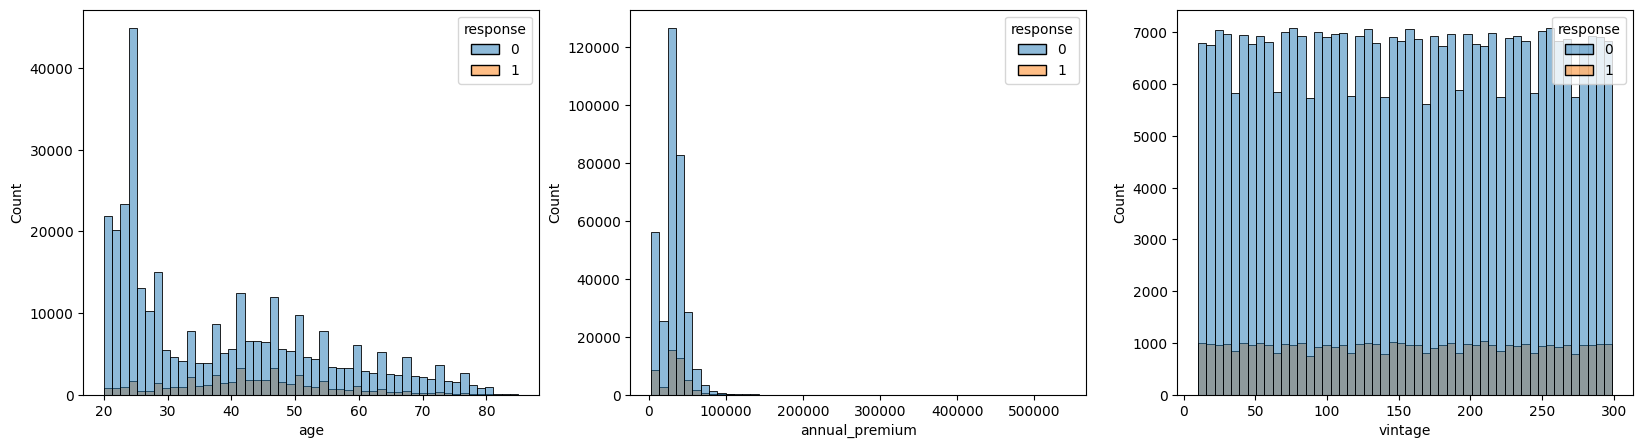

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
sns.histplot(data=df_train, x='age', hue='response', bins=50, ax=ax[0])
sns.histplot(data=df_train, x='annual_premium', bins=50, hue='response', ax=ax[1])
sns.histplot(data=df_train, x='vintage', hue='response', bins=50, ax=ax[2])

#### Categorical variables

In [74]:
cat_columns = df_train.select_dtypes(include='object').columns
cat_columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

<Axes: xlabel='driving_license', ylabel='count'>

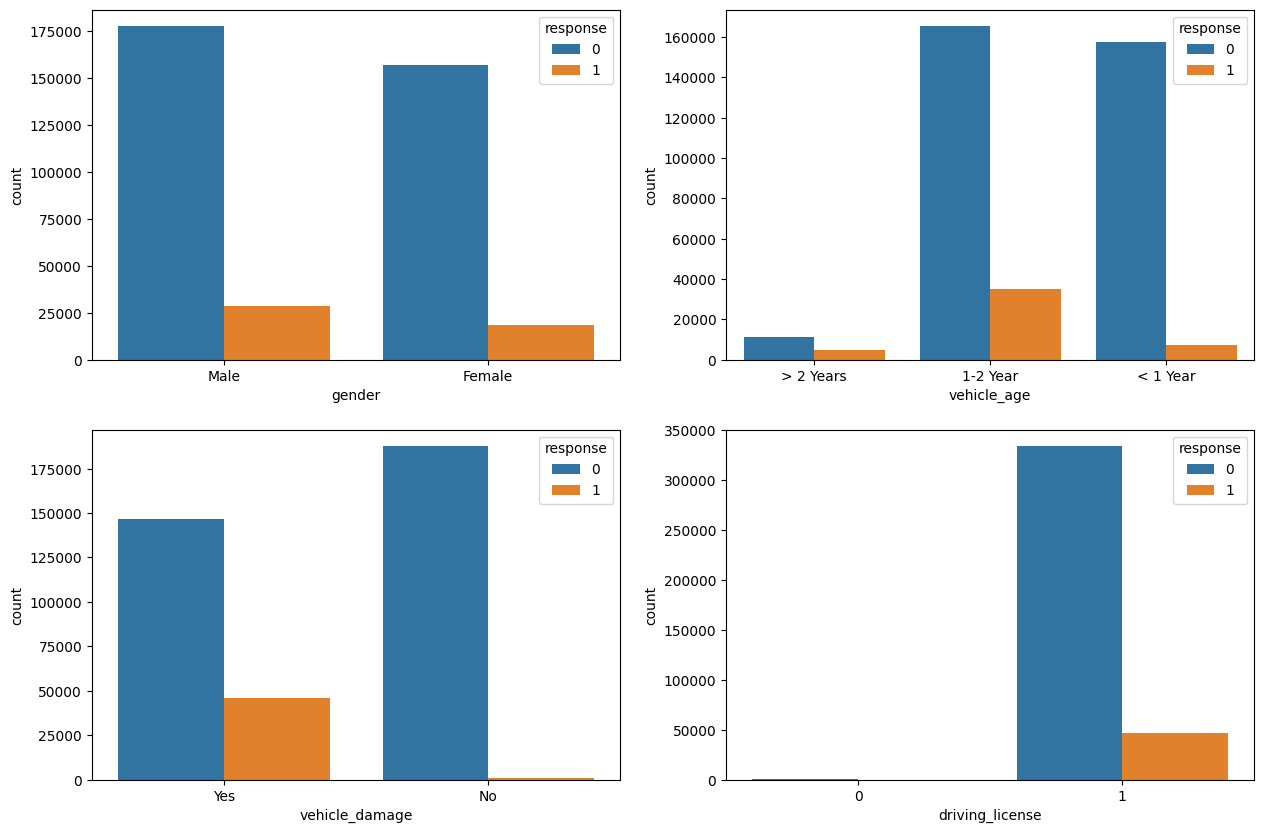

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.countplot(data=df_train, x='gender', hue='response', ax=ax[0][0])
sns.countplot(data=df_train, x='vehicle_age', hue='response', ax=ax[0][1])
sns.countplot(data=df_train, x='vehicle_damage', hue='response', ax=ax[1][0])
sns.countplot(data=df_train, x='driving_license', hue='response', ax=ax[1][1])

In [ ]:
df_train['driving_license']